## Bayesian model comparison

# Intuition

**FIGURE PLACEHOLDER:** ![Bayesian model comparison](image_placeholder)

# Notation



## Bayes Factor (BF) (recall Lecture 8)
The **Bayes Factor (BF)** (sometimes denoted as $K$) is defined as the ratio of the marginal likelihoods of two models, taking into account the prior distributions over the models' parameters. It is calculated as:

$$
BF(M_1, M_2) := \frac{Pr(D|M_1)}{Pr(D|M_2)} = \frac{\int Pr(D|\theta_1, M_1) Pr(\theta_1|M_1) d\theta_1}{\int Pr(D|\theta_2, M_2) Pr(\theta_2|M_2) d\theta_2} = \frac{\frac{Pr(M_1|D)Pr(D)}{Pr(M_1)} }{\frac{Pr(M_2|D)Pr(D)}{Pr(M_2)}} = \frac{Pr(M_1|D)}{Pr(M_2|D)} \times \frac{Pr(M_2)}{Pr(M_1)}
$$

The Bayes Factor compares the marginal likelihoods of the models after considering the uncertainty in the parameters, **weighted by the prior beliefs of the model**.


### Compare $M_1$ and $M_2$ based on data $D$
When comparing two models $M_1$ and $M_2$, we calculate the **posterior odds** for each model. The **posterior odds** represent the ratio of the posterior probabilities for the two models. This can be written as:

$$
\frac{P(M_1|D)}{P(M_2|D)} = \frac{P(D|M_1)P(M_1)}{P(D|M_2)P(M_2)}
$$

Where:
- $P(M_1|D)$ is the **posterior** probability of model $M_1$ given the data $D$.
- $P(M_2|D)$ is the **posterior** probability of model $M_2$ given the data $D$.
- $\frac{P(D|M_1)}{P(D|M_2)}$ is the **bayes factor** of $M_1$ and $M_2$
- $P(M_1)$ and $P(M_2)$ are the **prior probabilities** of models $M_1$ and $M_2$, respectively.

This ratio simplifies to:

$$
\text{Posterior Odds} = \text{Prior Odds} \times \text{Likelihood Ratio (LR)}
$$

Where:
- **Prior Odds** = $\frac{P(M_1)}{P(M_2)}$ is the ratio of prior probabilities of the models.
- **Likelihood Ratio (LR)** = $\frac{P(D|M_1)}{P(D|M_2)}$ is the ratio of the likelihoods of the data under each model.

Thus, the **posterior odds** can be updated by multiplying the **prior odds** by the **likelihood ratio**.

# Example

In [14]:
rm(list = ls()) # Clear the workspace
# Load necessary libraries
library(MASS)      # for multivariate normal
library(ggplot2)   # for plots
library(tibble)    # for tidy tables
library(dplyr)     # for data manipulatio

## Example 1 -- fine mapping

- Simulate Data

In [15]:
# Simulate Z-scores for 3 SNPs
Z <- c(5.1, 2.0, 1.8)
names(Z) <- c("SNP_A", "SNP_B", "SNP_C")

# Simulate LD matrix
R <- matrix(c(
  1.0, 0.8, 0.6,
  0.8, 1.0, 0.7,
  0.6, 0.7, 1.0
), nrow = 3, byrow = TRUE)
colnames(R) <- rownames(R) <- names(Z)


In [16]:
Z
R

SNP_A SNP_B SNP_C 
  5.1   2.0   1.8

,SNP_A,SNP_B,SNP_C
SNP_A,1.0,0.8,0.6
SNP_B,0.8,1.0,0.7
SNP_C,0.6,0.7,1.0


- Define Models for comparison

In [17]:
# Possible causal configurations (max 2 causal SNPs)
configs <- list(
  c(),                 # M0: null
  c(1), c(2), c(3),    # Single SNP
  c(1, 2), c(1, 3), c(2, 3)  # Pairs
)


- Compute Approximate Bayes Factors

We assume:
- Effect sizes $\sim N(0, \sigma^2)$
- $Z \sim N(R\beta, R)$


In [18]:
compute_abf <- function(causal_idx, Z, R, sigma2 = 0.05) {
  if (length(causal_idx) == 0) {
    return(1)  # model with no causal SNPs
  }
  # Subset R and Z
  R_c <- R[causal_idx, causal_idx, drop = FALSE]
  Z_c <- Z[causal_idx]
  V <- R_c + sigma2 * diag(length(causal_idx))
  exponent <- t(Z_c) %*% solve(V) %*% Z_c
  abf <- sqrt(det(R_c) / det(V)) * exp(0.5 * exponent)
  return(abf)
}

abfs <- sapply(configs, compute_abf, Z = Z, R = R)


- Compute Posterior Model Probabilities

In [19]:
# Set prior p(causal SNP) = 0.01
p <- 0.01
m <- length(Z)

# Prior on each model
model_priors <- sapply(configs, function(cfg) {
  k <- length(cfg)
  p^k * (1 - p)^(m - k)
})

In [20]:
# Posterior probabilities
unnorm_posteriors <- abfs * model_priors
posteriors <- unnorm_posteriors / sum(unnorm_posteriors)
posteriors

[1] 2.750877e-04 6.490657e-01 1.821666e-05 1.268515e-05 3.356221e-01
[6] 1.500606e-02 2.073618e-07

- Compute and Plot PIPs

In [21]:
# PIP for each SNP
pip <- setNames(rep(0, m), names(Z))
for (i in seq_along(configs)) {
  cfg <- configs[[i]]
  if (length(cfg) > 0) {
    pip[cfg] <- pip[cfg] + posteriors[i]
  }
}


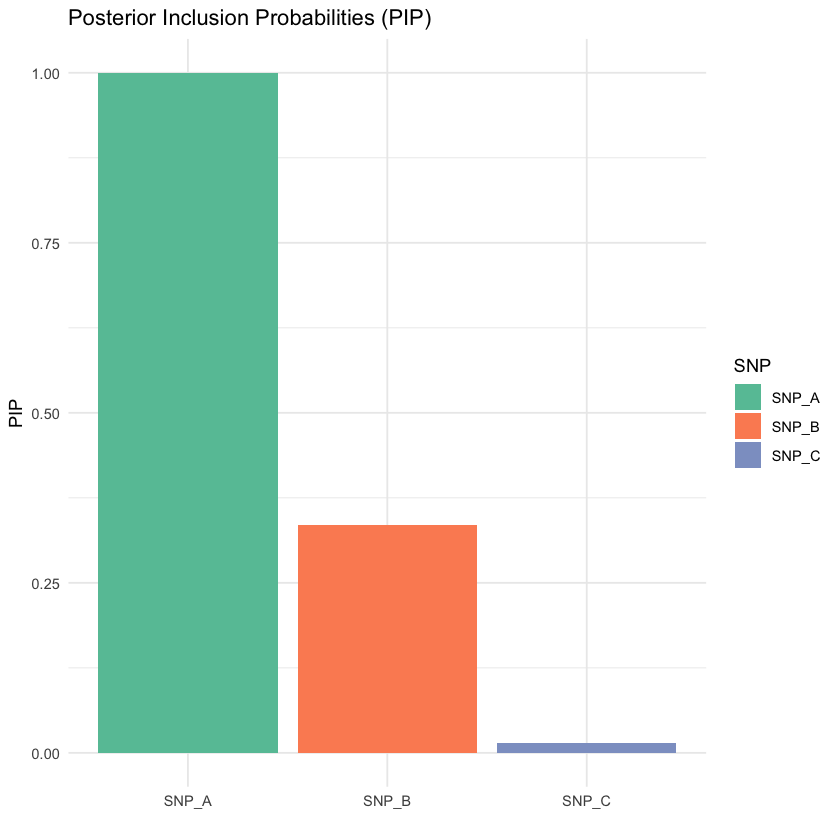

In [22]:
pip_df <- tibble(
  SNP = names(pip),
  PIP = pip
)

ggplot(pip_df, aes(x = SNP, y = PIP, fill = SNP)) +
  geom_bar(stat = "identity") +
  ylim(0, 1) +
  labs(title = "Posterior Inclusion Probabilities (PIP)",
       y = "PIP", x = "") +
  theme_minimal() +
  scale_fill_brewer(palette = "Set2")


## Example 2 -- multivariate regression

In [103]:
rm(list = ls())  # Clear workspace
library(MASS)     # For multivariate normal distribution
library(tibble)   # For tidy data

# --- 1. Define LD matrix for 3 SNPs ---
R <- matrix(c(
  1.0, 0.8, 0.2,
  0.8, 1.0, 0.7,
  0.2, 0.7, 1.0
), nrow = 3, byrow = TRUE)
colnames(R) <- rownames(R) <- c("SNP_A", "SNP_B", "SNP_C")


In [104]:
# --- 2. Simulate Z-scores for 2 traits ---
Z_trait1 <- c(5.0, 2.5, 1.5)  # Signal in SNP_A, others due to LD
Z_trait2 <- c(0.5, 0.2, -0.1) # No signal

Z <- rbind(Z_trait1, Z_trait2)
colnames(Z) <- c("SNP_A", "SNP_B", "SNP_C")
rownames(Z) <- c("Trait1", "Trait2")
print(Z)


       SNP_A SNP_B SNP_C
Trait1   5.0   2.5   1.5
Trait2   0.5   0.2  -0.1


In [105]:
# --- 3. Define models ---
models <- list(
  M0 = c(FALSE, FALSE),  # No effect
  M1 = c(TRUE, FALSE),   # Effect on Trait1 only
  M2 = c(FALSE, TRUE),   # Effect on Trait2 only
  M3 = c(TRUE, TRUE)     # Effect on both traits
)


In [106]:
# --- 4. Define log-likelihood function ---
log_likelihood <- function(z_vec, mu_vec, Sigma) {
  dist <- z_vec - mu_vec
  ll <- -0.5 * t(dist) %*% solve(Sigma) %*% dist  # Multivariate normal log-likelihood
  return(as.numeric(ll))
}


In [107]:
# --- 5. Compute log-likelihoods for each model ---
log_marg_liks <- sapply(models, function(effect_mask) {
  mu <- rep(0, 2)  # Initial effect sizes (set to zero)
  # Use a normal prior for the effect sizes, not hardcoded to 5
  mu[effect_mask] <- rnorm(sum(effect_mask), mean = 0, sd = 1)  # Sampling effect size from normal prior
  log_likelihood(Z[, "SNP_A"], mu, diag(2))  # Use diagonal covariance (independence across traits)
})

In [108]:
# --- 6. Calculate Bayes Factors and Posterior ---
log_BFs <- log_marg_liks - log_marg_liks["M0"]  # Compare to null model
BFs <- exp(log_BFs)
posterior <- BFs / sum(BFs)  # Normalize to get posterior probabilities

In [109]:
# --- 7. Output results ---
results <- tibble(
  Model = names(models),
  logLik = round(log_marg_liks, 2),
  BF = round(BFs, 2),
  PostProb = round(posterior, 3)
)

print(results)


# A tibble: 4 x 4
  Model logLik      BF PostProb
  <chr>  <dbl>   <dbl>    <dbl>
1 M0    -12.6     1       0.001
2 M1     -5.44 1322.      0.976
3 M2    -12.8     0.87    0.001
4 M3     -9.19   31.1     0.023
